In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, glob, random, time
import tensorflow as tf
import matplotlib.image as mpimg
import pickle as pk
import matplotlib.pyplot as plt
import keras
import numpy as np
import pandas as pd

from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

In [3]:
!rm -R /content/CatFaceCheck
!mkdir /content/CatFaceCheck
!cp /content/drive/MyDrive/Petfinding/FaceVerification/CatFaceCheck.zip /content/CatFaceCheck.zip
!unzip -q /content/CatFaceCheck.zip -d /content/CatFaceCheck

!rm -R /content/DogFaceCheck
!mkdir /content/DogFaceCheck
!cp /content/drive/MyDrive/Petfinding/FaceVerification/DogFaceCheck.zip /content/DogFaceCheck.zip
!unzip -q /content/DogFaceCheck.zip -d /content/DogFaceCheck

rm: cannot remove '/content/CatFaceCheck': No such file or directory
rm: cannot remove '/content/DogFaceCheck': No such file or directory


In [4]:
# Copy from training file
same_pet = 1
different_pet = 0

In [5]:
# Copy from training file
local_path = '/content'
remote_path = '/content/drive/MyDrive/Petfinding'

cat_pet_type_id = 1
dog_pet_type_id = 2
pet_type_ids = [cat_pet_type_id, dog_pet_type_id]

In [6]:
check_cat_images_path = local_path + '/CatFaceCheck/Images'
check_dog_images_path = local_path + '/DogFaceCheck/Images'

In [7]:
# Copy from training file
def image_paths_to_image_files(image_paths):
    image_files = []
    for image_path in image_paths:
        image_files += glob.glob(image_path + '/*.jpg')
    return image_files


def image_file_to_list(df):
    assert len(np.unique(df['pet_type_id'])) == 1 
    image_files = list(df['image_file'].values)
    image_files_len = len(image_files)
    return pd.Series([df.iloc[0]['pet_type_id'], image_files_len, image_files], index=['pet_type_id', 'image_files_len', 'image_files'])


def groupby_pet_id(df):
  sample_df = df.groupby('pet_id').apply(image_file_to_list).reset_index()
  return sample_df


In [8]:
# Copy from training file
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input


def create_face_features_for_image_file(efficient_net_model, image_file):
    image_bytes = image.load_img(image_file, target_size=(260, 260))
    image_bytes = image.img_to_array(image_bytes)
    image_bytes = np.expand_dims(image_bytes, axis=0)
    image_bytes = preprocess_input(image_bytes)
    return efficient_net_model.predict(image_bytes)


def create_face_features_for_image_files(efficient_net_model, image_files):
    image_files_to_face_features = {}
    for image_file in image_files:
      image_files_to_face_features[image_file] = create_face_features_for_image_file(efficient_net_model, image_file)
    return image_files_to_face_features


def create_face_features_pair(face_features_1, face_features_2):
    return np.concatenate((face_features_1, face_features_2), axis=1)


def create_face_features_pairs(image_file_pairs, image_file_to_face_features):
    face_features_pairs = []
    for image_file_pair in image_file_pairs:
        face_features_1 = image_file_to_face_features[image_file_pair[0]]
        face_features_2 = image_file_to_face_features[image_file_pair[1]]
        face_features_pairs.append(create_face_features_pair(face_features_1, face_features_2))
    
    face_features_pairs = np.stack(face_features_pairs, axis=0)
    face_features_pairs = np.array(face_features_pairs).reshape(len(image_file_pairs), -1)
    return face_features_pairs

    

In [9]:
efficient_net_model = keras.models.load_model(remote_path + '/Models/EfficientNet')
pca_model = pk.load(open(remote_path + '/Models/PCA.pkl','rb'))
svc_model = pk.load(open(remote_path + '/Models/SVC.pkl','rb'))

In [10]:
check_image_files = image_paths_to_image_files([check_cat_images_path, check_dog_images_path])

check_image_files_to_face_features = create_face_features_for_image_files(efficient_net_model, check_image_files)

In [11]:
check_image_files

['/content/CatFaceCheck/Images/y1235-2.jpg',
 '/content/CatFaceCheck/Images/v4235-1.jpg',
 '/content/CatFaceCheck/Images/n2134-1.jpg',
 '/content/CatFaceCheck/Images/n2134-2.jpg',
 '/content/CatFaceCheck/Images/q7523-0.jpg',
 '/content/CatFaceCheck/Images/s2345-1.jpg',
 '/content/CatFaceCheck/Images/s2345-0.jpg',
 '/content/CatFaceCheck/Images/n2134-0.jpg',
 '/content/CatFaceCheck/Images/v4235-0.jpg',
 '/content/CatFaceCheck/Images/y1235-0.jpg',
 '/content/CatFaceCheck/Images/s2345-2.jpg',
 '/content/CatFaceCheck/Images/y1235-1.jpg',
 '/content/CatFaceCheck/Images/q7523-1.jpg',
 '/content/DogFaceCheck/Images/512816-4.jpg',
 '/content/DogFaceCheck/Images/522863-1.jpg',
 '/content/DogFaceCheck/Images/522863-4.jpg',
 '/content/DogFaceCheck/Images/512816-1.jpg',
 '/content/DogFaceCheck/Images/519881-4.jpg',
 '/content/DogFaceCheck/Images/519881-3.jpg',
 '/content/DogFaceCheck/Images/3-0.jpg',
 '/content/DogFaceCheck/Images/2-0.jpg',
 '/content/DogFaceCheck/Images/524952-2.jpg',
 '/content/

0 = different pet, 1 = same pet

In [12]:
check_image_pair = [('/content/DogFaceCheck/Images/512816-4.jpg',
                     '/content/DogFaceCheck/Images/519881-2.jpg')]

x_check_face_features_pairs = create_face_features_pairs(check_image_pair, check_image_files_to_face_features)

x_check_face_features_pairs = pca_model.transform(x_check_face_features_pairs)

check_pred = svc_model.predict_proba(x_check_face_features_pairs)
check_pred

array([[0.97401952, 0.02598048]])

In [13]:
def compare_pets(pet_to_compare_image, other_pet_images):
    results = {}

    pet_to_compare_face_features = create_face_features_for_image_file(efficient_net_model, pet_to_compare_image)

    for other_pet_image in other_pet_images:
        other_pet_face_features = create_face_features_for_image_file(efficient_net_model, other_pet_image)

        face_features_pair = create_face_features_pair(pet_to_compare_face_features, other_pet_face_features)

        face_features_pair = pca_model.transform(face_features_pair)

        prediction = svc_model.predict_proba(face_features_pair)
        results[other_pet_image] = prediction[0][1]

    return results

In [14]:
results = compare_pets('/content/DogFaceCheck/Images/512816-4.jpg',
                       [
                        '/content/DogFaceCheck/Images/512816-2.jpg',   
                        '/content/DogFaceCheck/Images/512816-3.jpg',
                        '/content/DogFaceCheck/Images/512816-5.jpg',
                        '/content/DogFaceCheck/Images/512816-1.jpg',

                        
                        '/content/DogFaceCheck/Images/519881-2.jpg',
                        '/content/DogFaceCheck/Images/1-0.jpg',
                        '/content/CatFaceCheck/Images/y1235-2.jpg', 
                        '/content/CatFaceCheck/Images/y1235-1.jpg',
                        '/content/CatFaceCheck/Images/n2134-2.jpg',
                        '/content/CatFaceCheck/Images/q7523-0.jpg',
                        '/content/CatFaceCheck/Images/v4235-0.jpg',
                        '/content/CatFaceCheck/Images/s2345-0.jpg',
                        '/content/CatFaceCheck/Images/y1235-0.jpg',
                        '/content/CatFaceCheck/Images/n2134-0.jpg',
                        '/content/CatFaceCheck/Images/s2345-2.jpg',
                        '/content/DogFaceCheck/Images/519881-3.jpg',
                        '/content/DogFaceCheck/Images/522863-2.jpg',
                        '/content/DogFaceCheck/Images/524952-3.jpg',
                        '/content/DogFaceCheck/Images/519881-2.jpg',
                        '/content/DogFaceCheck/Images/2-0.jpg',
                        '/content/DogFaceCheck/Images/522863-3.jpg',
                        '/content/DogFaceCheck/Images/522863-1.jpg'
                        ])

In [15]:
results

{'/content/DogFaceCheck/Images/512816-2.jpg': 0.9577094152456744,
 '/content/DogFaceCheck/Images/512816-3.jpg': 0.9506343885516815,
 '/content/DogFaceCheck/Images/512816-5.jpg': 0.951659366053756,
 '/content/DogFaceCheck/Images/512816-1.jpg': 0.968584920679892,
 '/content/DogFaceCheck/Images/519881-2.jpg': 0.02598048300827138,
 '/content/DogFaceCheck/Images/1-0.jpg': 0.0015441544248421654,
 '/content/CatFaceCheck/Images/y1235-2.jpg': 0.7340046644217103,
 '/content/CatFaceCheck/Images/y1235-1.jpg': 0.26618515801831294,
 '/content/CatFaceCheck/Images/n2134-2.jpg': 0.12404292881488171,
 '/content/CatFaceCheck/Images/q7523-0.jpg': 0.18711239959892204,
 '/content/CatFaceCheck/Images/v4235-0.jpg': 0.055276170385330656,
 '/content/CatFaceCheck/Images/s2345-0.jpg': 0.19067971209498358,
 '/content/CatFaceCheck/Images/y1235-0.jpg': 0.29445444470901067,
 '/content/CatFaceCheck/Images/n2134-0.jpg': 0.3299804319768294,
 '/content/CatFaceCheck/Images/s2345-2.jpg': 0.1746240057409646,
 '/content/DogF

In [16]:
def get_ped_id(image_file):
    return image_file.split('/')[-1].split('-')[0];

In [17]:
# /content/CatFaceCheck/Images/v4235-1.jpg
# /content/CatFaceCheck/Images/n2134-1.jpg
# /content/DogFaceCheck/Images/519881-3.jpg
# /content/DogFaceCheck/Images/522863-2.jpg
image_file_to_compare = '/content/DogFaceCheck/Images/519881-3.jpg'
results = compare_pets(image_file_to_compare, check_image_files)

pet_id = get_ped_id(image_file_to_compare)

correct = 0
incorrect = 0
for image_file in results:
    result = results[image_file]
    if image_file.find(pet_id) == -1:
        if result > 0.5:
            print(f'{image_file}: {result:.4f} N')
            incorrect += 1
        else:
            # print(f'{image_file}: {result:.4f} Y')
            correct += 1
    else:
        if result < 0.5:
            print(f'{image_file}: {result:.4f} N')
            incorrect += 1
        else:
            print(f'{image_file}: {result:.4f} Y')
            correct += 1

print('Accuracy: {:.2f}%'.format((correct / (correct + incorrect)) * 100))

/content/DogFaceCheck/Images/519881-4.jpg: 0.8269 Y
/content/DogFaceCheck/Images/519881-3.jpg: 0.9219 Y
/content/DogFaceCheck/Images/524952-2.jpg: 0.5326 N
/content/DogFaceCheck/Images/519881-1.jpg: 0.9390 Y
/content/DogFaceCheck/Images/519881-2.jpg: 0.9245 Y
Accuracy: 97.14%


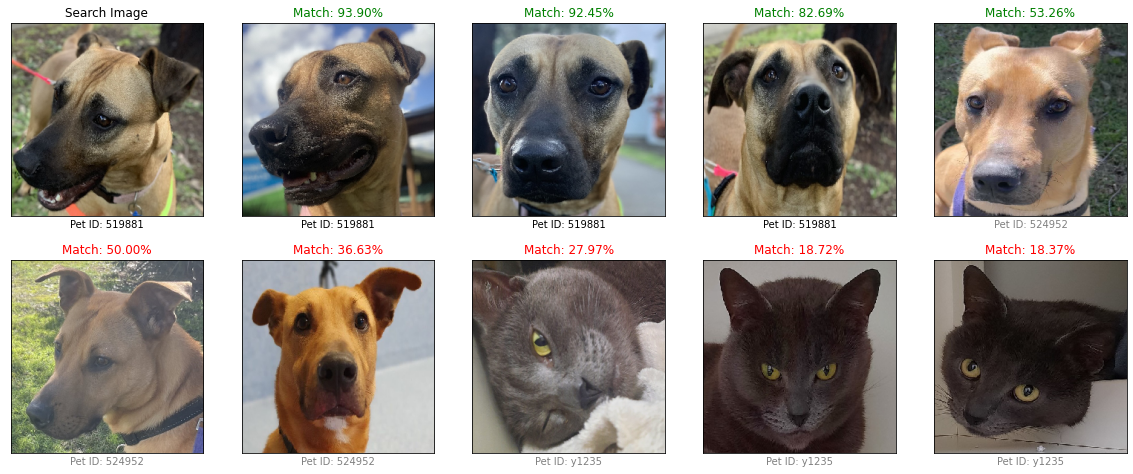

In [18]:
fig = plt.figure(figsize=(20, 8))

image_bytes = image.load_img(image_file_to_compare, target_size=(260, 260))

axes = fig.add_subplot(2, 5, 1)
axes.get_xaxis().set_ticks([])
axes.get_yaxis().set_ticks([])
axes.title.set_text('Search Image')
axes.set_xlabel('Pet ID: {}'.format(get_ped_id(image_file_to_compare)))
axes.imshow(image_bytes)

results.pop(image_file_to_compare, None)
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for i in range(9):
    image_bytes = image.load_img(sorted_results[i][0], target_size=(260, 260))
    axes = fig.add_subplot(2, 5, i + 2)
    axes.get_xaxis().set_ticks([])
    axes.get_yaxis().set_ticks([])
    if sorted_results[i][1] > 0.5:
        axes.title.set_color('green')
    else:
        axes.title.set_color('red')
    axes.title.set_text('Match: {:.2f}%'.format(sorted_results[i][1] * 100))
    axes.set_xlabel('Pet ID: {}'.format(get_ped_id(sorted_results[i][0])))
    if get_ped_id(image_file_to_compare) != get_ped_id(sorted_results[i][0]):
        axes.get_xaxis().label.set_color('grey')
    axes.imshow(image_bytes)

print()

In [22]:
import keras
import numpy as np
import pickle as pk
from keras import backend as K
from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input

class PetMatcher:
    def __init__(self, model_path):
        self.__efficient_net_model = keras.models.load_model(model_path + 'EfficientNet', compile=False)
        self.__pca_model = pk.load(open(model_path + 'PCA.pkl','rb'))
        self.__svc_model = pk.load(open(model_path + 'SVC.pkl','rb'))
    
    def match(self, pet_to_compare_image, other_pet_images):
        results = {}

        pet_to_compare_face_features = self.__create_face_features_for_image_file(pet_to_compare_image)

        for other_pet_image in other_pet_images:
            other_pet_face_features = self.__create_face_features_for_image_file(other_pet_image)

            face_features_pair = self.__create_face_features_pair(pet_to_compare_face_features, other_pet_face_features)

            face_features_pair = self.__pca_model.transform(face_features_pair)

            prediction = self.__svc_model.predict_proba(face_features_pair)
            results[other_pet_image] = round(prediction[0][1], 2)

        return sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    def __create_face_features_for_image_file(self, image_file):
        image_bytes = image.load_img(image_file, target_size=(260, 260))
        image_bytes = image.img_to_array(image_bytes)
        image_bytes = np.expand_dims(image_bytes, axis=0)
        image_bytes = preprocess_input(image_bytes)
        return self.__efficient_net_model.predict(image_bytes)
    
    def __create_face_features_pair(self, face_features_1, face_features_2):
        return np.concatenate((face_features_1, face_features_2), axis=1)

In [23]:
pet_matcher = PetMatcher('/content/drive/MyDrive/Petfinding/Models/')

In [24]:
pet_matcher.match('/content/CatFaceCheck/Images/y1235-2.jpg', ['/content/CatFaceCheck/Images/y1235-1.jpg', '/content/CatFaceCheck/Images/s2345-2.jpg', '/content/CatFaceCheck/Images/n2134-0.jpg'])

[('/content/CatFaceCheck/Images/y1235-1.jpg', 0.61),
 ('/content/CatFaceCheck/Images/s2345-2.jpg', 0.22),
 ('/content/CatFaceCheck/Images/n2134-0.jpg', 0.17)]

In [25]:
pet_matcher.match('/content/CatFaceCheck/Images/y1235-1.jpg', ['/content/CatFaceCheck/Images/y1235-2.jpg', '/content/CatFaceCheck/Images/s2345-2.jpg', '/content/CatFaceCheck/Images/n2134-0.jpg'])

[('/content/CatFaceCheck/Images/y1235-2.jpg', 0.87),
 ('/content/CatFaceCheck/Images/s2345-2.jpg', 0.41),
 ('/content/CatFaceCheck/Images/n2134-0.jpg', 0.13)]